## Supervise.ly bitmap-based label data from JSON to image 

- `PIL` is really installed as `pillow`
- `cv2` is really installed as `opencv`

```
conda create --name cv2 opencv pillow scikit-image numpy zlib matplotlib
```

In [1]:
import cv2
from PIL import Image
import zlib
import numpy as np
import io
import json
import base64
from skimage import io as skio
import matplotlib.pyplot as plt
import os
import glob

https://docs.supervise.ly/data-organization/import-export/supervisely-format#bitmap

Heeded a warning and changed `np.fromstring()` to `np.frombuffer()` and seems to work fine

In [2]:
def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3]
    return mask

def mask_2_base64(mask):
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

---

## same as polygon

In [4]:
data_dir = os.path.join('.','Book of Fortresses','Book of Fortresses')
ann_dir = os.path.join(data_dir,'ann')
img_dir = os.path.join(data_dir,'img')
mask_dir = os.path.join(data_dir,'mask')

ann_list = glob.glob(os.path.join(ann_dir,'*.json'))

ann_path = ann_list[0]
# remove .json extension – should maybe use pathlib instead...
img_filename = os.path.splitext(os.path.basename(ann_path))[0]
img_path = os.path.join(img_dir, img_filename)

In [5]:
try: 
    os.mkdir(mask_dir)
except OSError:
    if not os.path.exists(mask_dir):
        sys.exit("Error creating: " + mask_dir)

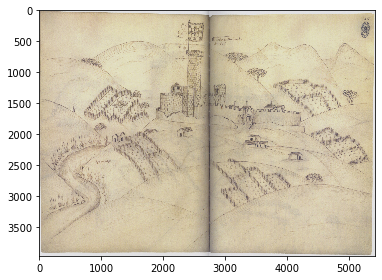

In [6]:
img = skio.imread(img_path)
skio.imshow(img);

In [7]:
img.shape

(3964, 5423, 3)

In [8]:
with open(ann_path,'r') as f:
    annotations = json.load(f)

In [9]:
for ii,ob in enumerate(annotations['objects']):
    print(ii, ob['id'], ob['geometryType'], end='')
    if ob['geometryType'] == 'polygon':
        print(' : exterior',len(ob['points']['exterior']),'interior',len(ob['points']['interior']))
    else:
        print('')

0 455524684 polygon : exterior 36 interior 0
1 455524879 polygon : exterior 46 interior 0
2 455525094 polygon : exterior 23 interior 0
3 455525139 polygon : exterior 16 interior 0
4 455525195 polygon : exterior 21 interior 0
5 455525319 polygon : exterior 19 interior 0
6 455525361 polygon : exterior 51 interior 0
7 455525387 polygon : exterior 115 interior 0
8 455525455 polygon : exterior 64 interior 0
9 455525565 polygon : exterior 225 interior 0
10 455525654 polygon : exterior 4 interior 0
11 455525667 polygon : exterior 9 interior 0
12 455525678 polygon : exterior 4 interior 0
13 455525686 polygon : exterior 7 interior 0
14 455525701 polygon : exterior 8 interior 0
15 455525741 bitmap
16 455525808 bitmap
17 455525835 bitmap
18 456895995 polygon : exterior 8 interior 0
19 456896102 polygon : exterior 27 interior 0
20 456896680 polygon : exterior 92 interior 0
21 456896903 polygon : exterior 85 interior 0
22 456897091 polygon : exterior 247 interior 0
23 456983070 polygon : exterior 3

In [10]:
ob = annotations['objects'][127]
ob

{'id': 457473824,
 'classId': 1525944,
 'description': '',
 'geometryType': 'polygon',
 'labelerLogin': 'edtriplett',
 'createdAt': '2020-06-04T20:23:43.679Z',
 'updatedAt': '2020-06-14T23:20:32.100Z',
 'tags': [{'id': 27891801,
   'name': '* Partially occluded or Complete?',
   'value': 'Complete',
   'labelerLogin': 'edtriplett',
   'createdAt': '2020-06-04T21:03:28.784Z',
   'updatedAt': '2020-06-04T21:03:28.784Z'},
  {'id': 27898698,
   'name': '* Flag Affiliation',
   'value': 'Portugal',
   'labelerLogin': 'edtriplett',
   'createdAt': '2020-06-04T21:03:24.433Z',
   'updatedAt': '2020-06-04T21:03:24.433Z'},
  {'id': 27898700,
   'name': '* Flag shape',
   'value': 'Rectangular',
   'labelerLogin': 'edtriplett',
   'createdAt': '2020-06-04T21:03:34.072Z',
   'updatedAt': '2020-06-04T21:03:34.072Z'}],
 'classTitle': 'Flag',
 'points': {'exterior': [[2413, 196],
   [2411, 180],
   [2424, 148],
   [2434, 174],
   [2430, 197],
   [2452, 202],
   [2476, 208],
   [2491, 213],
   [2507, 

In [11]:
bitmap = ob['bitmap']
mask = base64_2_mask(bitmap['data'])
skio.imshow(mask);

KeyError: 'bitmap'

In [12]:
# (rmin,rmax),(cmin,cmax) = bbox2(mask_img[:,:,3])
# To get all the way cropped should really add 1 to rmin. Not sure why...

cc0,rr0 = bitmap['origin']
rr,cc = mask.shape

NameError: name 'bitmap' is not defined

In [ ]:
crop_test = img[slice(rr0,rr0+rr), slice(cc0,cc0+cc), :3]
print(crop_test.shape)
print(mask.shape)
skio.imshow(crop_test)

In [ ]:
img_masked_sm = np.zeros((rr,cc,4), dtype=np.uint8)

img_masked_sm[:,:,:3] = img[slice(rr0,rr0+rr), slice(cc0,cc0+cc), :3]
img_masked_sm[:,:,3] = mask
skio.imshow(img_masked_sm);

In [17]:
# supervisely/plugins/dtl/legacy_supervisely_lib/figure/figure_line.py
# shape_hw = bitmap.shape[:2]
def to_uint8_mask(exterior, interiors, shape_hw):
    bmp_to_draw = np.zeros(shape_hw, np.uint8)
    cv2.fillPoly(bmp_to_draw, pts=[exterior], color=255)
    cv2.fillPoly(bmp_to_draw, pts=interiors, color=0)
    to_contours = [interior[:, np.newaxis, :] for interior in interiors]
    # cv2.drawContours(bmp_to_draw, to_contours, contourIdx=-1, color=255)
    return bmp_to_draw

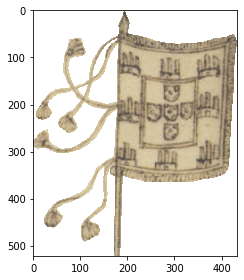

In [27]:
# NOTE: Just exterior points for now...
#   If doing polygon regions with holes, need to create that shape logic code
points = ob['points']
exterior = np.round(points['exterior']).astype('int')
interiors = [np.round(x).astype('int') for x in points['interior']]

# Do the crop before creating masked image

[cmin,rmin] = exterior.min(axis=0)
[cmax,rmax] = exterior.max(axis=0)
exterior_offset = exterior - exterior.min(axis=0)

img_masked = np.zeros((rmax-rmin,cmax-cmin,4), dtype=np.uint8)
mask = to_uint8_mask(exterior, interiors, img.shape[:2])

img_masked[:,:,:3] = img[slice(rmin,rmax), slice(cmin,cmax), :3]
img_masked[:,:,3] = mask[slice(rmin,rmax), slice(cmin,cmax)]

skio.imshow(img_masked);

In [25]:
[exterior]

[array([[2413,  196],
        [2411,  180],
        [2424,  148],
        [2434,  174],
        [2430,  197],
        [2452,  202],
        [2476,  208],
        [2491,  213],
        [2507,  216],
        [2535,  220],
        [2568,  218],
        [2595,  214],
        [2614,  208],
        [2640,  205],
        [2655,  198],
        [2663,  216],
        [2659,  233],
        [2657,  257],
        [2655,  286],
        [2655,  318],
        [2652,  352],
        [2650,  394],
        [2647,  439],
        [2647,  458],
        [2643,  485],
        [2635,  496],
        [2615,  503],
        [2590,  506],
        [2568,  511],
        [2544,  511],
        [2520,  513],
        [2496,  513],
        [2475,  513],
        [2453,  507],
        [2436,  504],
        [2424,  500],
        [2419,  501],
        [2414,  669],
        [2401,  670],
        [2404,  501],
        [2395,  496],
        [2393,  491],
        [2393,  480],
        [2386,  503],
        [2386,  523],
        [2

In [24]:
bmp_to_draw = np.zeros(img_masked.shape[:2], np.uint8)

cv2.fillPoly(bmp_to_draw, pts=[exterior], color=1).max()


0

---

## old base64